In [1]:
from itertools import product
import graspy as gp
import numpy as np
import pandas as pd
from hyppo.ksample import KSample
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns


from src import estimate_embeddings
%matplotlib inline

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [53]:
def generate_2_block_dirichlet(alpha_1, alpha_2, block_size):
    X = np.random.dirichlet(alpha_1, block_size)
    Y = np.random.dirichlet(alpha_2, block_size)
    out = np.vstack([X, Y])
    
    return out

def generate_graphs(latent_positions, num_graphs):
    pmat = gp.simulations.p_from_latent(latent_positions, loops=False)
    graphs = np.array([gp.simulations.sample_edges(pmat, loops=False) for _ in range(num_graphs)])
    return graphs

def generate_dirichlet_graphs(alpha_1, alpha_2, block_size, num_graphs, resample_latent=False):
    if resample_latent:
        X = []
        Y = []
        
        for _ in range(num_graphs):
            latent_positions_1 = generate_2_block_dirichlet(alpha_1, alpha_1, block_size)
            latent_positions_2 = generate_2_block_dirichlet(alpha_1, alpha_2, block_size)

            X.append(generate_graphs(latent_positions_1, 1))
            Y.append(generate_graphs(latent_positions_2, 1))
            
        X = np.vstack(X)
        Y = np.vstack(Y) 
    else:
        latent_positions_1 = generate_2_block_dirichlet(alpha_1, alpha_1, block_size)
        latent_positions_2 = generate_2_block_dirichlet(alpha_1, alpha_2, block_size)
        
        X = generate_graphs(latent_positions_1, num_graphs)
        Y = generate_graphs(latent_positions_2, num_graphs)

    return X, Y

In [54]:
def experiment(m, n, effect_size, reps=100):
    block_size = n // 2
    m_per_pop = m // 2
    
    alpha_1 = [1, 1]
    alpha_2 = [1, 1 + effect_size]
    
    pvals = np.zeros((reps, 3, n))

    for i in range(reps):
        X, Y = generate_dirichlet_graphs(alpha_1, alpha_2, block_size, m_per_pop)

        for node in range(n):
            test = KSample("Dcorr").test(X[:, node, :], Y[:, node, :])
            pvals[i, 0, node] = test[1]
        
        for j, method in enumerate(['omni', 'mase'], start=1):
            embeddings = estimate_embeddings(X, Y, method, 2, sample_space=True)
            Xhat = embeddings[:m_per_pop]
            Yhat = embeddings[m_per_pop:]
            for node in range(n):
                test = KSample("Dcorr").test(Xhat[:, node, :], Yhat[:, node, :])
                pvals[i, j, node] = test[1]

    pvals = pvals < 0.05    
    pvals = pvals.mean(axis=0)
    avg_pval_1 = pvals[:, :block_size].mean(axis=1)
    avg_pval_2 = pvals[:, block_size:].mean(axis=1)

    to_append = [m, n, effect_size, *avg_pval_1, *avg_pval_2]
    return to_append

In [55]:
ms = np.linspace(0, 200, 6, dtype=int)[1:]
ns = np.linspace(0, 200, 6, dtype=int)[1:]
effect_sizes = [0, 0.2, 10]

args = [dict(m=m, n=n, effect_size=effect_size) for m, n, effect_size in product(ms, ns, effect_sizes)]
args = sum(zip(reversed(args), args), ())[: len(args)]

In [56]:
res = Parallel(-1, verbose=4)(delayed(experiment)(**arg) for arg in args)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  75 | elapsed:  5.2min remaining: 33.7min
[Parallel(n_jobs=-1)]: Done  29 out of  75 | elapsed: 12.9min remaining: 20.5min
[Parallel(n_jobs=-1)]: Done  48 out of  75 | elapsed: 41.7min remaining: 23.5min
[Parallel(n_jobs=-1)]: Done  67 out of  75 | elapsed: 157.5min remaining: 18.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 197.2min finished


In [57]:
columns = ["m", "n", "effect_size", 
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff"]

df = pd.DataFrame(res, columns=columns)
df = df.sort_values(['effect_size', 'n','m'])
df.to_csv("./results/dirichlet_powers_no_resample.csv", index=False)

Text(-0.03, 0.5, 'Number of Graphs (m)')

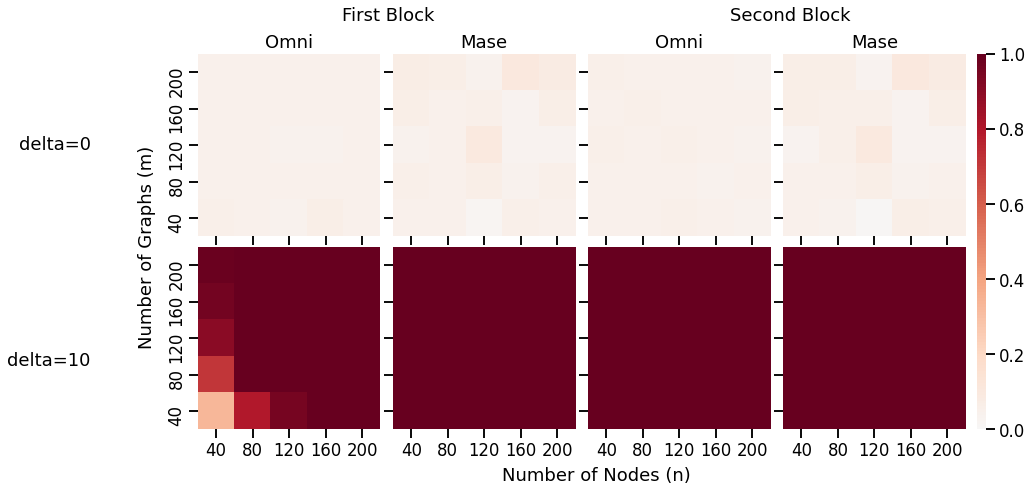

In [46]:
sns.set_context('talk')

fig, ax = plt.subplots(
    2, 
    5, 
    figsize=(12, 6),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"width_ratios": [1, 1, 1, 1, 0.05]},
)

gs = ax[-1, -1].get_gridspec()
for ax_ in ax[:, -1]:
    ax_.remove()
ax_leg = fig.add_subplot(gs[:, -1])

col_names = ['Omni', 'Mase']

for row, effect_size in enumerate([0, 10]):
    for col, method in enumerate(['omni_same', 'mase_same', 'omni_diff', 'mase_diff']):
        tmp = df[df.effect_size == effect_size][method]
        sns.heatmap(
            np.flipud(tmp.values.reshape(5, 5)),
            square=True,
            cmap='RdBu_r',
            center=0,
            cbar_ax=ax_leg,
            ax = ax[row, col],
            xticklabels=ns,
            yticklabels=ms[::-1],
            vmin=0,
            vmax=1
        )

        if row == 0:
            ax[row, col].set_title(col_names[col % 2])

fig.text(0.26, 1.035, "First Block", va="center", ha="center")
fig.text(0.725, 1.035, "Second Block", va="center", ha="center")

fig.text(-0.085, 0.225, "delta=10", ha="right")
#fig.text(-0.085, 0.5, "delta=0.02", ha="right")
fig.text(-0.085, 0.725, "delta=0", ha="right")

fig.text(0.5, -0.03, "Number of Nodes (n)", va="center", ha="center")
fig.text(-0.03, 0.5, "Number of Graphs (m)", va="center", rotation="vertical")

Text(-0.03, 0.5, 'Number of Graphs (m)')

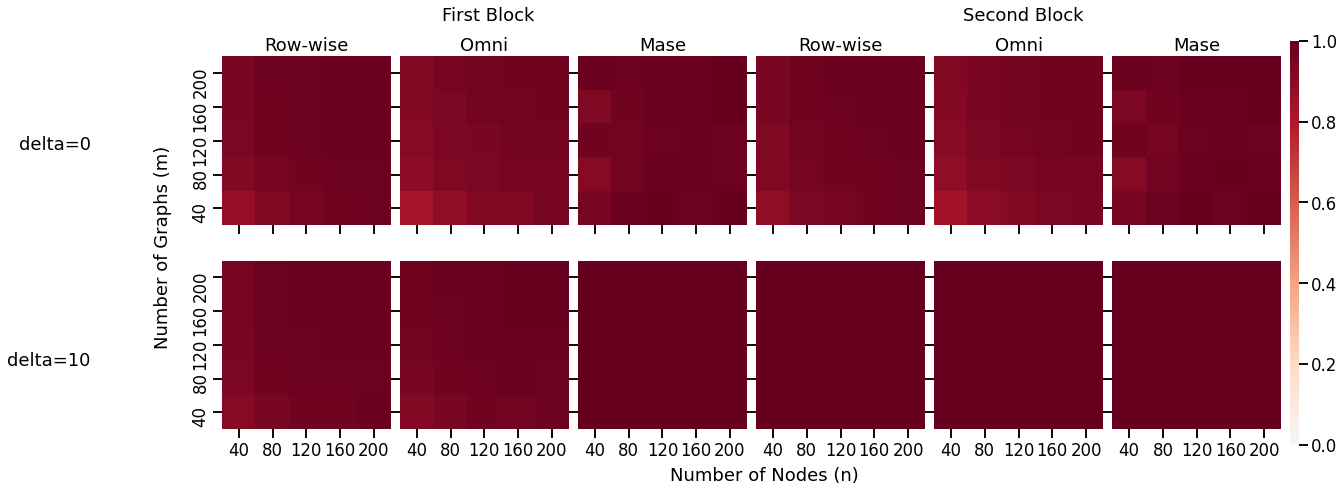

In [58]:
sns.set_context('talk')

fig, ax = plt.subplots(
    2, 
    7, 
    figsize=(16, 6),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"width_ratios": [1, 1, 1, 1, 1, 1, 0.05]},
)

gs = ax[-1, -1].get_gridspec()
for ax_ in ax[:, -1]:
    ax_.remove()
ax_leg = fig.add_subplot(gs[:, -1])

col_names = ["Row-wise", 'Omni', 'Mase']

for row, effect_size in enumerate([0, 10]):
    for col, method in enumerate(df.columns[3:]):
        tmp = df[df.effect_size == effect_size][method]
        sns.heatmap(
            np.flipud(tmp.values.reshape(5, 5)),
            square=True,
            cmap='RdBu_r',
            center=0,
            cbar_ax=ax_leg,
            ax = ax[row, col],
            xticklabels=ns,
            yticklabels=ms[::-1],
            vmin=0,
            vmax=1
        )

        if row == 0:
            ax[row, col].set_title(col_names[col % 3])
        
fig.text(0.26, 1.035, "First Block", va="center", ha="center")
fig.text(0.725, 1.035, "Second Block", va="center", ha="center")
        
fig.text(-0.085, 0.225, "delta=10", ha="right")
#fig.text(-0.085, 0.5, "delta=0.02", ha="right")
fig.text(-0.085, 0.725, "delta=0", ha="right")

fig.text(0.5, -0.03, "Number of Nodes (n)", va="center", ha="center")
fig.text(-0.03, 0.5, "Number of Graphs (m)", va="center", rotation="vertical")

In [52]:
df[df.effect_size == 10]

,m,n,effect_size,row_wise_same,omni_same,mase_same,row_wise_diff,omni_diff,mase_diff
5,40,40,10.0,0.050000,0.331500,0.993,1.0,1.0,1.0
35,80,40,10.0,0.055000,0.797500,1.000,1.0,1.0,1.0
65,120,40,10.0,0.068000,0.957000,1.000,1.0,1.0,1.0
54,160,40,10.0,0.091500,0.998000,1.000,1.0,1.0,1.0
24,200,40,10.0,0.112500,1.000000,1.000,1.0,1.0,1.0
11,40,80,10.0,0.050250,0.713500,1.000,1.0,1.0,1.0
41,80,80,10.0,0.063500,0.992250,1.000,1.0,1.0,1.0
71,120,80,10.0,0.081750,1.000000,1.000,1.0,1.0,1.0
48,160,80,10.0,0.112250,1.000000,1.000,1.0,1.0,1.0
18,200,80,10.0,0.148750,1.000000,1.000,1.0,1.0,1.0
